In [21]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [23]:

# Define hyperparameters
image_size = 784
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=r'N:\deep learning\MNIST\MNIST\MNIST',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_dataset = torchvision.datasets.MNIST(root=r'N:\deep learning\MNIST\MNIST\MNIST',
                                          train=False,
                                          transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Create directory to save the reconstructed and sampled images (if directory not present)
sample_dir = 'results'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [13]:
# VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(image_size, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)
        log_var = self.fc2_logvar(h)
        return mu, log_var
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        return out
    
    def forward(self, x):
        # x: (batch_size, 1, 28,28) --> (batch_size, 784)
        mu, logvar = self.encode(x.view(-1, image_size))
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

# Define model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        

In [14]:
# Define Loss
def loss_function(reconstructed_image, original_image, mu, logvar):
    bce = F.binary_cross_entropy(reconstructed_image, original_image.view(-1, 784), reduction = 'sum')
    # kld = torch.sum(0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar, 1))
    kld = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
    return bce + kld
    

# Train function
def train(epoch):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        reconstructed, mu, logvar = model(images)
        loss = loss_function(reconstructed, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % 100 == 0:
            print("Train Epoch {} [Batch {}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), loss.item()/len(images)))
            
    print('=====> Epoch {}, Average Loss: {:.3f}'.format(epoch, train_loss/len(train_loader.dataset)))



In [15]:

# Test function
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(test_loader):
            images = images.to(device)
            reconstructed, mu, logvar = model(images)
            test_loss += loss_function(reconstructed, images, mu, logvar).item()
            if batch_idx == 0:
                comparison = torch.cat([images[:5], reconstructed.view(batch_size, 1, 28, 28)[:5]])
                save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = 5)

    print('=====> Average Test Loss: {:.3f}'.format(test_loss/len(test_loader.dataset)))

Train Epoch 1 [Batch 0/469]	Loss: 108.837
Train Epoch 1 [Batch 100/469]	Loss: 113.272
Train Epoch 1 [Batch 200/469]	Loss: 109.514
Train Epoch 1 [Batch 300/469]	Loss: 109.570
Train Epoch 1 [Batch 400/469]	Loss: 109.197
=====> Epoch 1, Average Loss: 108.470
=====> Average Test Loss: 107.233
Train Epoch 2 [Batch 0/469]	Loss: 107.203
Train Epoch 2 [Batch 100/469]	Loss: 105.523
Train Epoch 2 [Batch 200/469]	Loss: 106.664
Train Epoch 2 [Batch 300/469]	Loss: 104.465
Train Epoch 2 [Batch 400/469]	Loss: 108.432
=====> Epoch 2, Average Loss: 107.638
=====> Average Test Loss: 106.539
Train Epoch 3 [Batch 0/469]	Loss: 107.392
Train Epoch 3 [Batch 100/469]	Loss: 110.846
Train Epoch 3 [Batch 200/469]	Loss: 104.642
Train Epoch 3 [Batch 300/469]	Loss: 101.922
Train Epoch 3 [Batch 400/469]	Loss: 102.908
=====> Epoch 3, Average Loss: 106.958
=====> Average Test Loss: 106.574
Train Epoch 4 [Batch 0/469]	Loss: 104.947
Train Epoch 4 [Batch 100/469]	Loss: 107.330
Train Epoch 4 [Batch 200/469]	Loss: 110.105


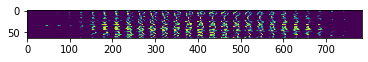

In [24]:

# Main function
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        # Get rid of the encoder and sample z from the gaussian ditribution and feed it to the decoder to generate samples
        sample = torch.randn(64,20).to(device)
        generated = model.decode(sample).cpu()
        plt.imshow(generated)
        save_image(generated.view(64,1,28,28), 'results/sample_' + str(epoch) + '.png')